In [3]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.keras.applications.vgg19 import VGG19

2.2.0


In [4]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [5]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#convert image into array then cast to input format for VGG16
def load_and_process_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    #print(img.shape)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    #print(img.shape)
    return img

In [7]:
#Accept images in array and De-normalize them.
def deprocess(x):
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x
#Accept images in De-normalized form and plot them
def display_image(image):
    if len(image.shape) == 4:
        image = np.squeeze(image, axis = 0)

    img = deprocess(image)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

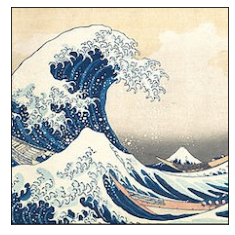

In [8]:
img = load_and_process_image('style.jpg')
display_image(img)

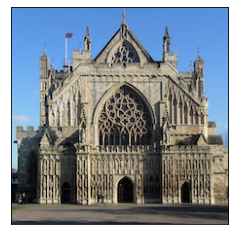

In [9]:
img = load_and_process_image('content.jpg')
display_image(img)

In [10]:
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]

In [11]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [12]:
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

In [13]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

In [14]:
import time

generated_images = []
cost=[]
def training_loop(content_path, style_path, iterations = 1000, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype = tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(1,iterations+1):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        cost.append(J_total)
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if (i % 10 == 0) or (i == 1):
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [15]:
final = training_loop('content.jpg','style.jpg')

Cost at 1: 13733986304.0. Time elapsed: 2.8981244564056396
Cost at 10: 1825320960.0. Time elapsed: 6.594884634017944
Cost at 20: 784932672.0. Time elapsed: 10.718386888504028
Cost at 30: 462509952.0. Time elapsed: 14.852787733078003
Cost at 40: 320229184.0. Time elapsed: 19.002906322479248
Cost at 50: 246601472.0. Time elapsed: 23.17072892189026
Cost at 60: 203576960.0. Time elapsed: 27.325652360916138
Cost at 70: 175789344.0. Time elapsed: 31.470081090927124
Cost at 80: 156523248.0. Time elapsed: 35.62213921546936
Cost at 90: 142291376.0. Time elapsed: 39.76146483421326
Cost at 100: 131181160.0. Time elapsed: 43.895609617233276
Cost at 110: 122264504.0. Time elapsed: 48.03483986854553
Cost at 120: 114960232.0. Time elapsed: 52.167532205581665
Cost at 130: 108765120.0. Time elapsed: 56.299158573150635
Cost at 140: 103371840.0. Time elapsed: 60.435492277145386
Cost at 150: 98636856.0. Time elapsed: 64.56694197654724
Cost at 160: 94438912.0. Time elapsed: 68.71420454978943
Cost at 170: 9

In [16]:
plt.figure(figsize = (18, 18))

for i in range(100):
    plt.subplot(10, 10, i + 1)
    display_image(generated_images[i])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

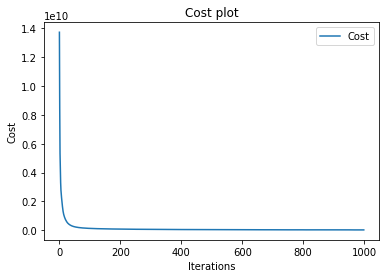

In [17]:
import matplotlib.pyplot as plt
plt.plot(cost,label='Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost plot')
plt.legend()
plt.show()

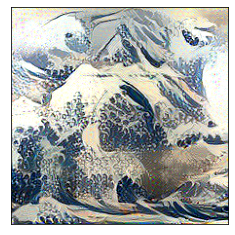

In [18]:
display_image(final)